In [1]:
import os
import re
import random
from argparse import Namespace

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm
import torchaudio
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

import sacrebleu
import sentencepiece

from fairseq import utils
from fairseq.data import PhonemeDictionary, Dictionary, data_utils as fairseq_data_utils
from fairseq.models.speech_to_text.xstnet import XSTNet
from fairseq.data.audio.speech_text_triple_align_dataset import (
    SpeechTextTripleAlignDataset
)
from fairseq.data.audio.speech_to_text_dataset import get_features_or_waveform, _collate_frames
from ConST.prepare_data.data_utils import load_df_from_tsv, save_df_to_tsv
from fairseq.checkpoint_utils import load_checkpoint_to_cpu, save_state, torch_persistent_save

In [2]:
device = 'cuda:7'

# Load Checkpoints

In [3]:
args = Namespace()
task = Namespace()

args.w2v2_model_path = '/mnt/data/siqiouyang/runs/mST/pretrained/wav2vec_small.pt'

args.max_audio_positions = 600000
args.max_source_positions = 1024
args.max_target_positions = 1024
args.max_audio_tokens = 1000000
args.max_text_tokens = 2000
args.max_tokens = 1000000
args.max_tokens_valid = 2000000

src_dict = PhonemeDictionary.load('/mnt/data/siqiouyang/datasets/must-c-v1.0/phonemes.txt')
tgt_dict = Dictionary.load('/mnt/data/siqiouyang/datasets/must-c-v1.0/spm_unigram10000_st_de.txt')
task.source_dictionary = src_dict
task.target_dictionary = tgt_dict

token_model = XSTNet.build_model(args, task)
sent_model = XSTNet.build_model(args, task)

In [4]:
token_tag = 'ablation_pretrain_token_ft_1h'
sent_tag = 'ablation_pretrain_sent_ft_1h'

In [5]:
token_ckpt_path = '/mnt/data/siqiouyang/runs/ConST/{}/checkpoint_best.pt'.format(token_tag)
token_ckpt = load_checkpoint_to_cpu(token_ckpt_path)
token_model.load_state_dict(token_ckpt['model'])
token_model = token_model.to(device)
token_model.eval()

XSTNet(
  (encoder): XSTNetEncoder(
    (embed_tokens): Embedding(10000, 512, padding_idx=1)
    (dropout_module): FairseqDropout()
    (wav2vec_model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
            (3): GELU()
          )
          (1): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): GELU()
          )
          (2): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): GELU()
          )
          (3): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (

In [6]:
sent_ckpt_path = '/mnt/data/siqiouyang/runs/ConST/{}/checkpoint_best.pt'.format(sent_tag)
sent_ckpt = load_checkpoint_to_cpu(sent_ckpt_path)
sent_model.load_state_dict(sent_ckpt['model'])
sent_model = sent_model.to(device)
sent_model.eval()

XSTNet(
  (encoder): XSTNetEncoder(
    (embed_tokens): Embedding(10000, 512, padding_idx=1)
    (dropout_module): FairseqDropout()
    (wav2vec_model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): Fp32GroupNorm(512, 512, eps=1e-05, affine=True)
            (3): GELU()
          )
          (1): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): GELU()
          )
          (2): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (1): Dropout(p=0.0, inplace=False)
            (2): GELU()
          )
          (3): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
            (

# ST Generation

In [7]:
def extract(path):
    refs = []
    gens = []
    with open(path, 'r') as r:
        for line in r.readlines():
            line = line.strip()
            parts = line.split('\t')
            if line.startswith('T-'):
                refs.append(parts[1])
            elif line.startswith('D-'):
                gens.append(parts[2])
    return refs, gens

In [8]:
refs, token_gens = extract('../generation/{}/generate-tst-COMMON_st_de.txt'.format(token_tag))
refs, sent_gens = extract('../generation/{}/generate-tst-COMMON_st_de.txt'.format(sent_tag))

In [9]:
refs = np.array(refs)
token_gens = np.array(token_gens)
sent_gens = np.array(sent_gens)
token_bleu = []
for ref, gen in zip(refs, token_gens):
    token_bleu.append(sacrebleu.sentence_bleu(gen, [ref]).score)
sent_bleu = []
for ref, gen in zip(refs, sent_gens):
    sent_bleu.append(sacrebleu.sentence_bleu(gen, [ref]).score)
token_bleu = np.array(token_bleu)
sent_bleu = np.array(sent_bleu)

In [10]:
better_mask = token_bleu > sent_bleu

In [11]:
sorted_indices = (sent_bleu / token_bleu).argsort()

# Compute Feature

In [12]:
def dtw(a, b):
    n = a.size(0)
    m = b.size(0)

    f = th.zeros(n, m)

    for i in range(n):
        for j in range(m):
            d = ((a[i] - b[j]) ** 2).sum() ** 0.5

            rest = 1e9
            if i > 0:
                rest = min(rest, f[i - 1, j])
            if j > 0:
                rest = min(rest, f[i, j - 1])
            if i > 0 and j > 0:
                rest = min(rest, f[i - 1, j - 1])
            if i == 0 and j == 0:
                rest = 0

            f[i, j] = d + rest
    
    return f[n - 1, m - 1] / max(n, m)

In [13]:
spm = sentencepiece.SentencePieceProcessor()
spm.Load('/mnt/data/siqiouyang/datasets/must-c-v1.0/spm_unigram10000_st_de.model')

True

In [14]:
df = load_df_from_tsv('/mnt/data/siqiouyang/datasets/must-c-v1.0/tst-COMMON_st_de.tsv')

In [240]:
# 15, 44, 48
sorted_idx = 48
df_idx = (df['tgt_text'] == refs[sorted_indices[sorted_idx]]).argmax()

In [233]:
align_path = '/mnt/data/siqiouyang/datasets/must-c-v1.0/en-de/data/tst-COMMON/align/{}.pt'.format(df['id'][df_idx])
os.path.exists(align_path)
def compute_feature(model, df_idx):
    align_path = '/mnt/data/siqiouyang/datasets/must-c-v1.0/en-de/data/tst-COMMON/align/{}.pt'.format(df['id'][df_idx])
    if os.path.exists(align_path):
        audio_path = os.path.join('/mnt/data/siqiouyang/datasets/must-c-v1.0', df['audio'][df_idx])
        audio = get_features_or_waveform(audio_path, need_waveform=True)
        tokenized =  " ".join(spm.EncodeAsPieces(df['src_text'][df_idx]))
        src_text = tgt_dict.encode_line(
            tokenized, add_if_not_exist=False, append_eos=True
        ).long()
        lang_tag = SpeechTextTripleAlignDataset.LANG_TAG_TEMPLATE.format(df['src_lang'][df_idx])
        lang_tag_idx = tgt_dict.index(lang_tag)
        src_text = th.cat((th.LongTensor([lang_tag_idx]), src_text), 0).unsqueeze(0)
        n_frame = th.LongTensor([audio.size(1)])
        src_length = th.LongTensor([src_text.size(1)])

        with th.no_grad():
            st_encoder_out = model.encoder(audio.to(device), n_frame.to(device))
            st_x = st_encoder_out.encoder_out.squeeze(1).cpu()
            mt_encoder_out = model.encoder(src_text.to(device), src_length.to(device), is_text_input=True)
            mt_x = mt_encoder_out.encoder_out.squeeze(1).cpu()

        seg, itv = th.load(align_path)
        seg = [(s[0] + 1, s[1] + 1) for s in seg]
        itv = (itv * st_encoder_out.encoder_padding_mask.size(1)).astype(int)
        st_f = []
        mt_f = []
        tokens = []
        for (t_l, t_r), (s_l, s_r) in zip(seg, itv):
            st_f.append(st_x[s_l : s_r + 1].mean(dim=0))
            mt_f.append(mt_x[t_l : t_r + 1].mean(dim=0))
            tokens.append(''.join([tgt_dict.symbols[t] for t in src_text[0][t_l : t_r + 1]]).replace('▁', ''))
        st_f = th.stack(st_f, dim=0)
        mt_f = th.stack(mt_f, dim=0)
        
        return st_x, st_f, mt_x, mt_f, src_text[0], tokens

    return None

    # seg, itv = th.load(align_path)
    # seg = [(s[0] + 1, s[1] + 1) for s in seg]
    # itv = (itv * st_encoder_out.encoder_padding_mask.size(1)).astype(int)
    # st_f = []
    # mt_f = []
    # for (t_l, t_r), (s_l, s_r) in zip(seg, itv):
    #     st_f.append(st_x[s_l : s_r + 1].mean(dim=0))
    #     mt_f.append(mt_x[t_l : t_r + 1].mean(dim=0))
    # st_f = th.stack(st_f, dim=0)
    # mt_f = th.stack(mt_f, dim=0)
audio_path = os.path.join('/mnt/data/siqiouyang/datasets/must-c-v1.0', df['audio'][df_idx])
audio = get_features_or_waveform(audio_path, need_waveform=True)
torchaudio.save('example.wav', audio, 16000)
token_st_x, token_st_f, token_mt_x, token_mt_f, src_text, tokens = compute_feature(token_model, df_idx)
token_sim_matrix = F.cosine_similarity(
    token_mt_f.unsqueeze(1),
    token_st_f.unsqueeze(0),
    dim=-1
)
# plt.title('Speech-Transcript Feature Alignment Matrix (Model-Token)')
# plt.savefig('{}/word.png'.format(sorted_idx))
sent_st_x, sent_st_f, sent_mt_x, sent_mt_f, src_text, tokens = compute_feature(sent_model, df_idx)
sent_sim_matrix = F.cosine_similarity(
    sent_mt_f.unsqueeze(1),
    sent_st_f.unsqueeze(0),
    dim=-1
)

In [234]:
print('ref               : {}'.format(refs[sorted_indices[sorted_idx]]), \
    'token, BLEU {:.2f} : {}'.format(token_bleu[sorted_indices[sorted_idx]], token_gens[sorted_indices[sorted_idx]]), \
    'sent , BLEU {:.2f} : {}'.format(sent_bleu[sorted_indices[sorted_idx]], sent_gens[sorted_indices[sorted_idx]]), sep='\n')

ref               : Manchmal ist die Perspektive die Illusion.
token, BLEU 100.00 : Manchmal ist die Perspektive die Illusion.
sent , BLEU 13.13 : Wie oft ist die Sichtweise die Lösung.


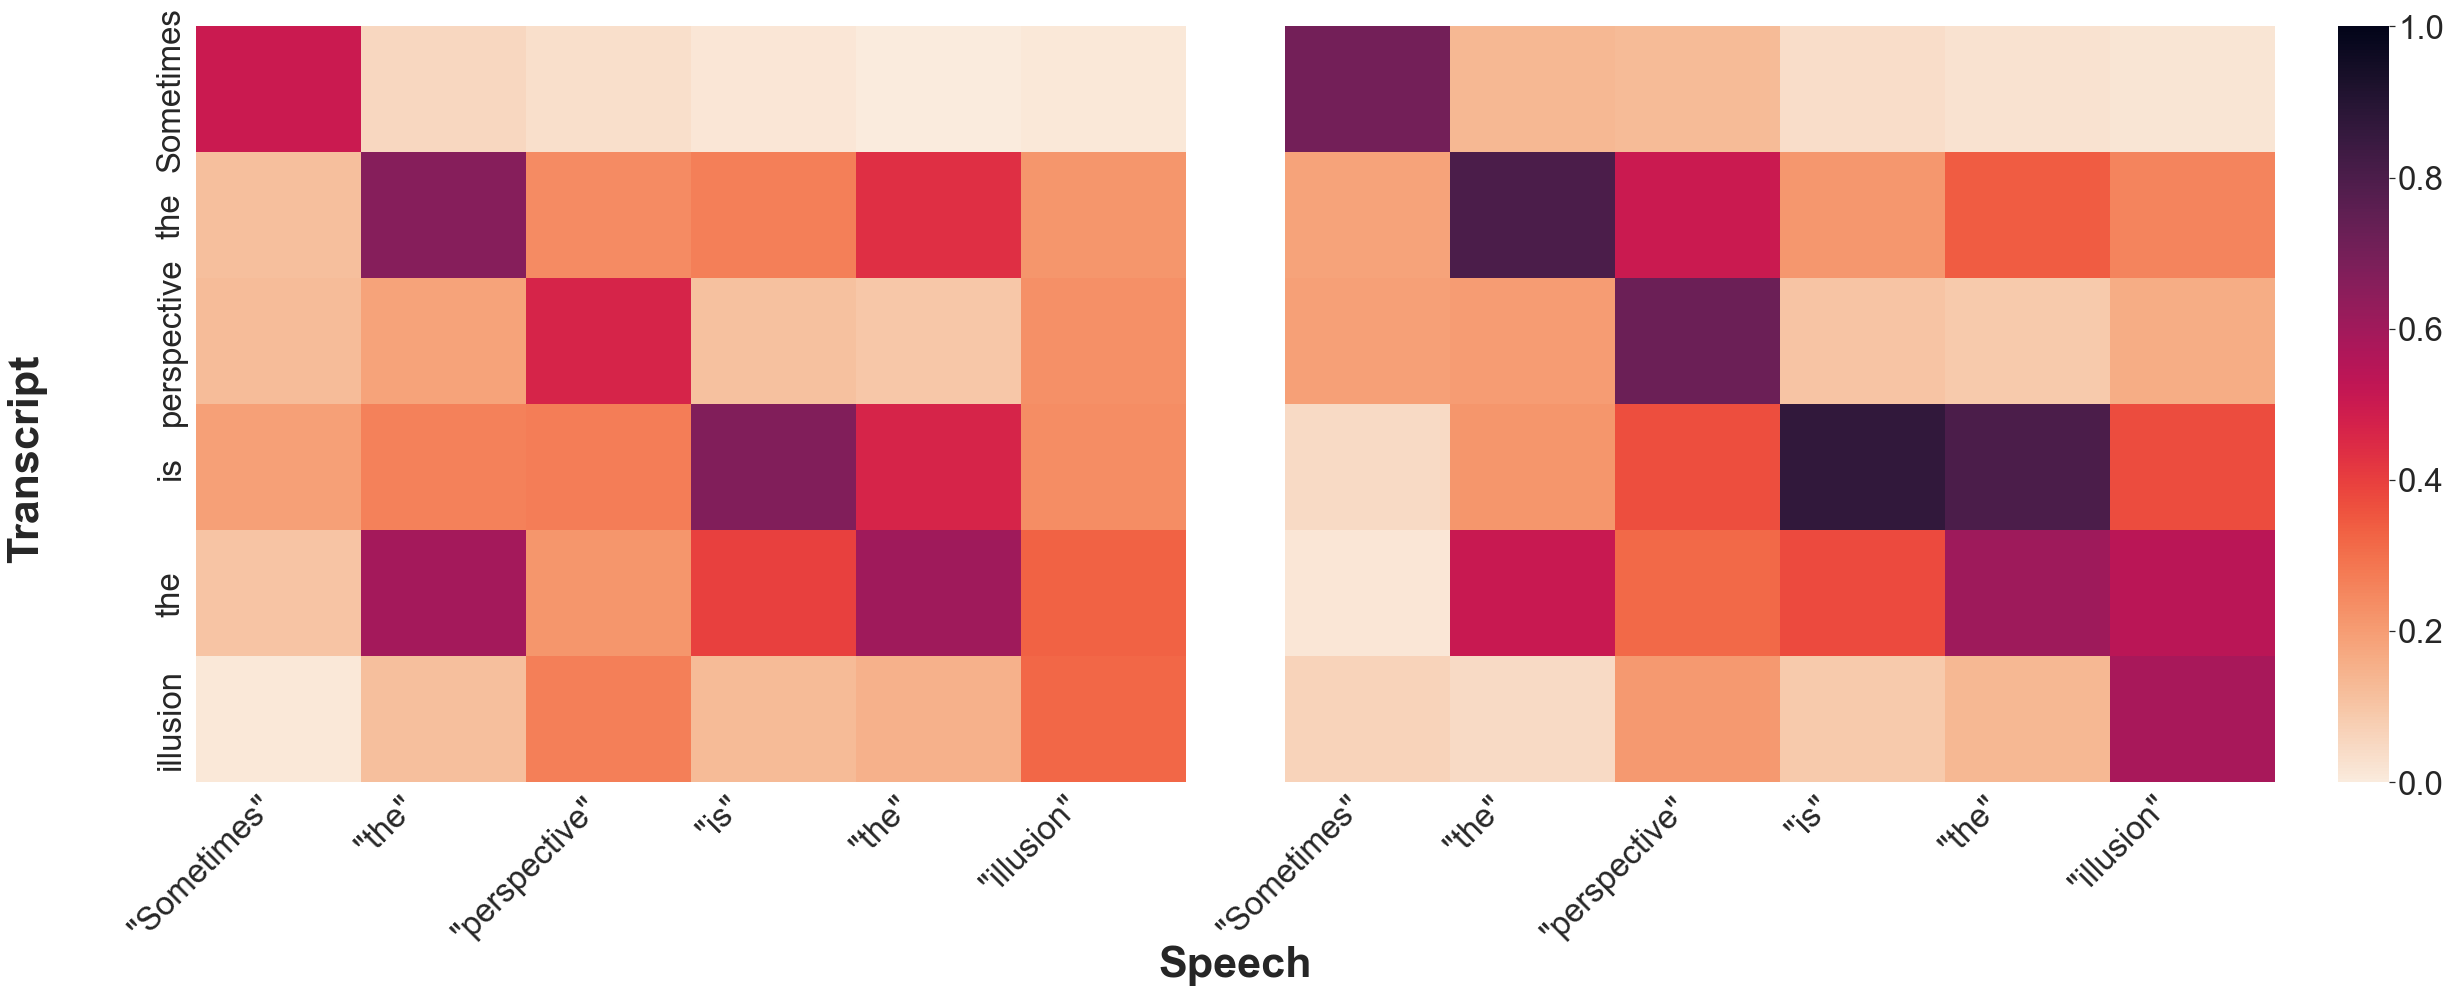

In [238]:
# 44

sns.set(font_scale=3)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 15))

# axes[1].set_title('WACO')
sns.heatmap(token_sim_matrix.detach().cpu(), ax=axes[1], yticklabels=[], vmin=0, vmax=1, cmap='rocket_r', cbar=False)

xticklabels = ['"{}"'.format(t) for t in tokens]
maxl = max(len(lb) for lb in xticklabels)
xticklabels = [' ' * (maxl - len(lb)) + lb for lb in xticklabels]

axes[1].set_xticks(range(len(tokens)), xticklabels, rotation=45, rotation_mode='default', va='top', ha='center')

fig.subplots_adjust(bottom=0.2, top=0.9, left=0.075, right=0.9, wspace=0.1)
cbar_ax = fig.add_axes([0.925, 0.2, 0.02, 0.7])

# axes[0].set_title('ConST')
sns.heatmap(sent_sim_matrix.detach().cpu(), ax=axes[0], yticklabels=tokens, vmin=0, vmax=1, cmap='rocket_r', cbar_ax=cbar_ax)

axes[0].set_xticks(range(len(tokens)), xticklabels, rotation=45, rotation_mode='default', va='top', ha='center')

# sns.set(font_scale=2.5)
fig.text(0.4875, 0.02, 'Speech', ha='center', size='large', fontweight='bold')
fig.text(0.0, 0.5, 'Transcript', va='center', rotation='vertical', size='large', fontweight='bold')

os.makedirs('{}'.format(sorted_idx), exist_ok=True)
plt.savefig('{}/case_{}.svg'.format(sorted_idx, sorted_idx))

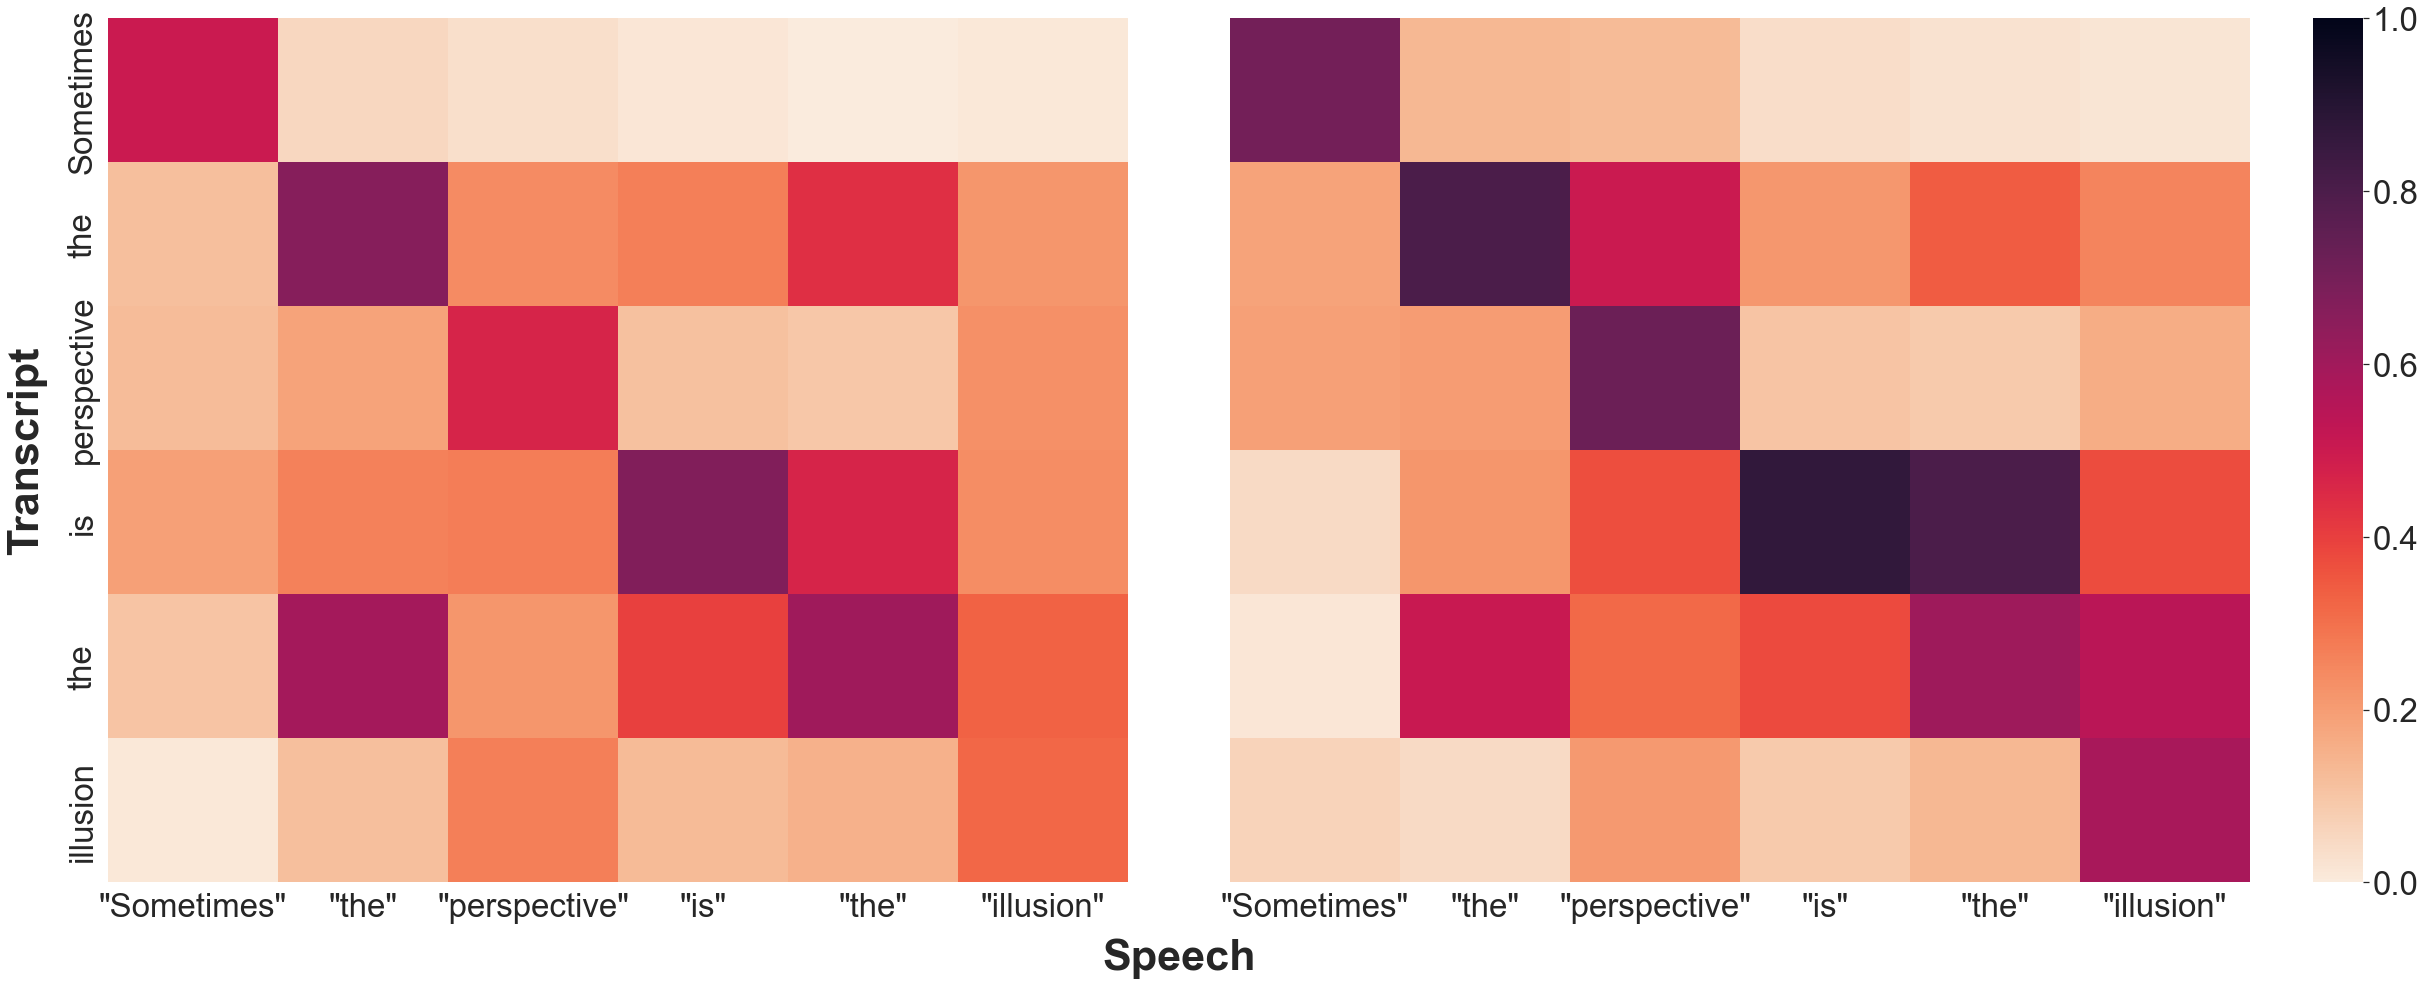

In [245]:
# 15, 48

sns.set(font_scale=3)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(35, 15))


# axes[1].set_title('WACO')
sns.heatmap(token_sim_matrix.detach().cpu(), ax=axes[1], yticklabels=[], xticklabels=['"{}"'.format(t) for t in tokens], vmin=0, vmax=1, cmap='rocket_r', cbar=False)

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.9, wspace=0.1)
cbar_ax = fig.add_axes([0.925, 0.1, 0.02, 0.8])

# axes[0].set_title('ConST')
sns.heatmap(sent_sim_matrix.detach().cpu(), ax=axes[0], yticklabels=tokens, xticklabels=['"{}"'.format(t) for t in tokens], vmin=0, vmax=1, cmap='rocket_r', cbar_ax=cbar_ax)

fig.text(0.475, 0.02, 'Speech', ha='center', size='large', fontweight='bold')
fig.text(0.01, 0.5, 'Transcript', va='center', rotation='vertical', size='large', fontweight='bold')

os.makedirs('{}'.format(sorted_idx), exist_ok=True)
plt.savefig('{}/case_{}.svg'.format(sorted_idx, sorted_idx))

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15))
fig.subplots_adjust(bottom=0, top=15, left=0, right=30)
cbar_ax = fig.add_axes([28, 15, 2, 15])

sns.set(font_scale=2.0)
sns.heatmap(token_sim_matrix.detach().cpu(), ax=axes[0], yticklabels=tokens, xticklabels=['"{}"'.format(t) for t in tokens], vmin=0, vmax=1, cmap='rocket_r', cbar=False)
# plt.xlabel('Speech')
# plt.ylabel('Text')

# plt.figure(dpi=100, figsize=(15, 10))
sns.set(font_scale=2.0)
sns.heatmap(sent_sim_matrix.detach().cpu(), ax=axes[1], yticklabels=tokens, xticklabels=['"{}"'.format(t) for t in tokens], vmin=0, vmax=1, cmap='rocket_r', cbar=False)
# plt.xlabel('Speech', size='large', fontweight='bold')
# plt.ylabel('Text')

# # plt.title('Speech-Transcript Feature Alignment Matrix (Model-Sentence)')
# plt.savefig('{}/sent.png'.format(sorted_idx))

# print('ref               : {}'.format(refs[sorted_indices[sorted_idx]]), \
#     'token, BLEU {:.2f} : {}'.format(token_bleu[sorted_indices[sorted_idx]], token_gens[sorted_indices[sorted_idx]]), \
#     'sent , BLEU {:.2f} : {}'.format(sent_bleu[sorted_indices[sorted_idx]], sent_gens[sorted_indices[sorted_idx]]), sep='\n')

# print('\nPooled Sentence Similarity: model-token {:.2f}, model-sent {:.2f}'.format(
#     F.cosine_similarity(token_st_x.mean(dim=0), token_mt_x.mean(dim=0), dim=0),
#     F.cosine_similarity(sent_st_x.mean(dim=0), sent_mt_x.mean(dim=0), dim=0)
# ))

# print('\nDTW Distance: model-token {:.2f}, model-sent {:.2f}'.format(
#     dtw(token_st_x, token_mt_x),
#     dtw(sent_st_x, sent_mt_x),
# ))

<AxesSubplot:>

Error in callback <function flush_figures at 0x7f50ef51b940> (for post_execute):


KeyboardInterrupt: 

In [114]:
align_path = '/mnt/data/siqiouyang/datasets/must-c-v1.0/en-de/data/tst-COMMON/align/{}.pt'.format(df['id'][df_idx])
os.path.exists(align_path)

True

In [115]:
def compute_feature(model, df_idx):
    align_path = '/mnt/data/siqiouyang/datasets/must-c-v1.0/en-de/data/tst-COMMON/align/{}.pt'.format(df['id'][df_idx])
    if os.path.exists(align_path):
        audio_path = os.path.join('/mnt/data/siqiouyang/datasets/must-c-v1.0', df['audio'][df_idx])
        audio = get_features_or_waveform(audio_path, need_waveform=True)
        tokenized =  " ".join(spm.EncodeAsPieces(df['src_text'][df_idx]))
        src_text = tgt_dict.encode_line(
            tokenized, add_if_not_exist=False, append_eos=True
        ).long()
        lang_tag = SpeechTextTripleAlignDataset.LANG_TAG_TEMPLATE.format(df['src_lang'][df_idx])
        lang_tag_idx = tgt_dict.index(lang_tag)
        src_text = th.cat((th.LongTensor([lang_tag_idx]), src_text), 0).unsqueeze(0)
        n_frame = th.LongTensor([audio.size(1)])
        src_length = th.LongTensor([src_text.size(1)])

        with th.no_grad():
            st_encoder_out = model.encoder(audio.to(device), n_frame.to(device))
            st_x = st_encoder_out.encoder_out.squeeze(1).cpu()
            mt_encoder_out = model.encoder(src_text.to(device), src_length.to(device), is_text_input=True)
            mt_x = mt_encoder_out.encoder_out.squeeze(1).cpu()

        seg, itv = th.load(align_path)
        seg = [(s[0] + 1, s[1] + 1) for s in seg]
        itv = (itv * st_encoder_out.encoder_padding_mask.size(1)).astype(int)
        st_f = []
        mt_f = []
        tokens = []
        for (t_l, t_r), (s_l, s_r) in zip(seg, itv):
            st_f.append(st_x[s_l : s_r + 1].mean(dim=0))
            mt_f.append(mt_x[t_l : t_r + 1].mean(dim=0))
            tokens.append(''.join([tgt_dict.symbols[t] for t in src_text[0][t_l : t_r + 1]]).replace('▁', ''))
        st_f = th.stack(st_f, dim=0)
        mt_f = th.stack(mt_f, dim=0)
        
        return st_f, mt_f, src_text[0], tokens

    return None

    # seg, itv = th.load(align_path)
    # seg = [(s[0] + 1, s[1] + 1) for s in seg]
    # itv = (itv * st_encoder_out.encoder_padding_mask.size(1)).astype(int)
    # st_f = []
    # mt_f = []
    # for (t_l, t_r), (s_l, s_r) in zip(seg, itv):
    #     st_f.append(st_x[s_l : s_r + 1].mean(dim=0))
    #     mt_f.append(mt_x[t_l : t_r + 1].mean(dim=0))
    # st_f = th.stack(st_f, dim=0)
    # mt_f = th.stack(mt_f, dim=0)

In [116]:
audio_path = os.path.join('/mnt/data/siqiouyang/datasets/must-c-v1.0', df['audio'][df_idx])

In [117]:
audio = get_features_or_waveform(audio_path, need_waveform=True)

<AxesSubplot:>

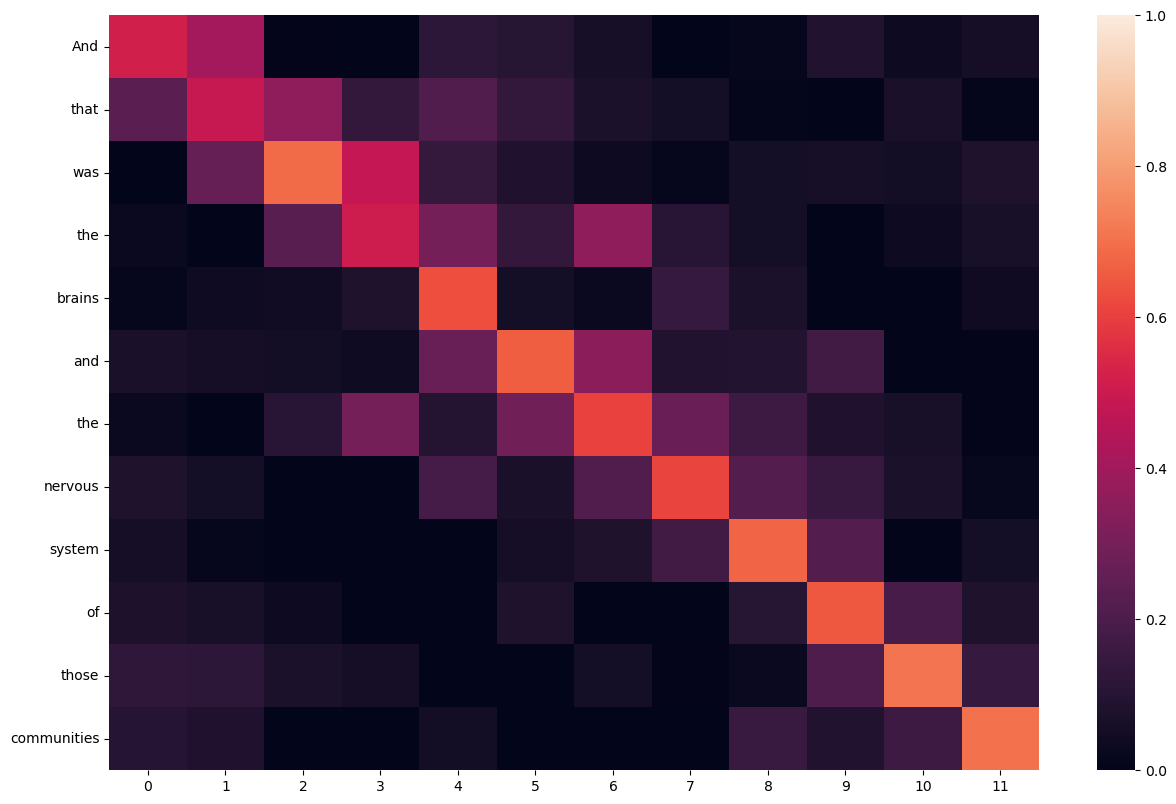

In [118]:
token_st_x, token_mt_x, src_text, tokens = compute_feature(token_model, df_idx)
token_sim_matrix = F.cosine_similarity(
    token_mt_x.unsqueeze(1),
    token_st_x.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100, figsize=(15, 10))
sns.heatmap(token_sim_matrix.detach().cpu(), yticklabels=tokens, vmin=0, vmax=1)

<AxesSubplot:>

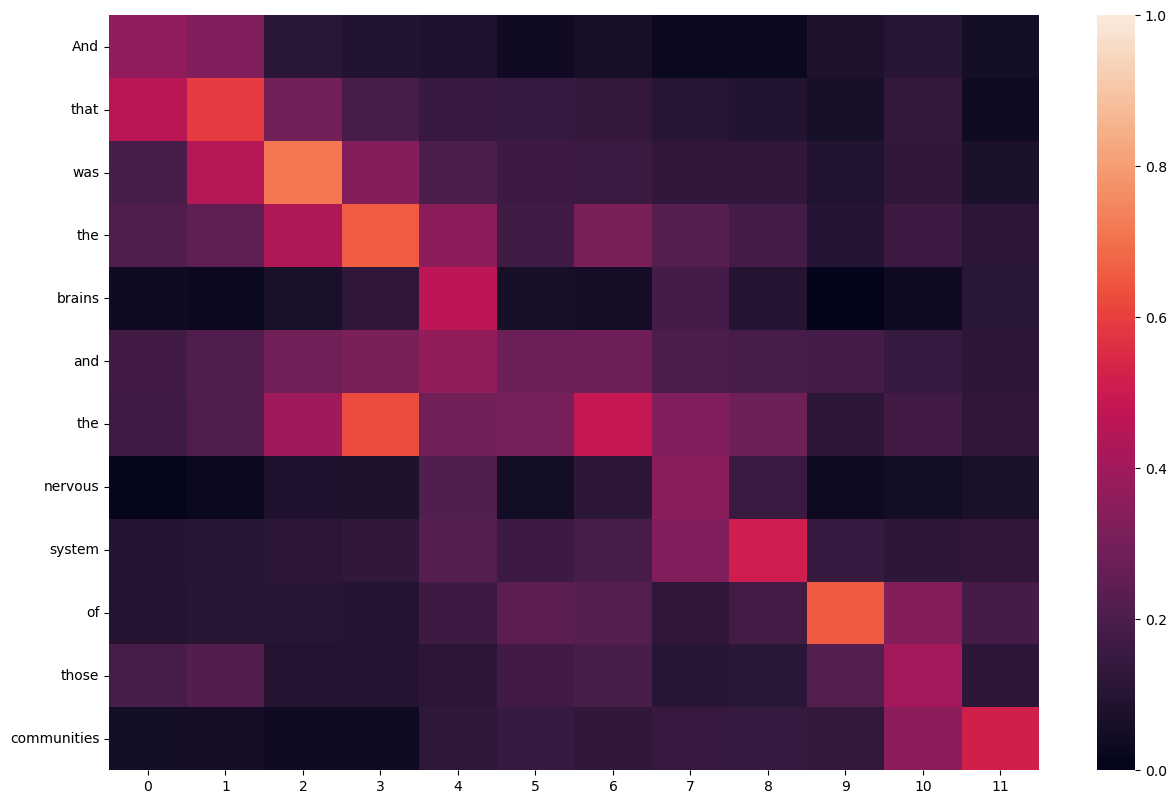

In [119]:
sent_st_x, sent_mt_x, src_text, tokens = compute_feature(sent_model, df_idx)
sent_sim_matrix = F.cosine_similarity(
    sent_mt_x.unsqueeze(1),
    sent_st_x.unsqueeze(0),
    dim=-1
)
plt.figure(dpi=100, figsize=(15, 10))
sns.heatmap(sent_sim_matrix.detach().cpu(), yticklabels=tokens, vmin=0, vmax=1)

In [120]:
print('ref               : {}'.format(refs[sorted_indices[sorted_idx]]), \
    'token, BLEU {:.2f} : {}'.format(token_bleu[sorted_indices[sorted_idx]], token_gens[sorted_indices[sorted_idx]]), \
    'sent , BLEU {:.2f} : {}'.format(sent_bleu[sorted_indices[sorted_idx]], sent_gens[sorted_indices[sorted_idx]]), sep='\n')

ref               : Und dies war das Gehirn und das Nervensystem dieser Gemeinschaften.
token, BLEU 46.78 : Das waren die Gehirne und das Nervensystem dieser Gemeinschaften.
sent , BLEU 3.80 : Das waren die Gehirne des iranischen Systems der Gemeinschaft.
